In [1]:
import pandas as pd
import numpy as np
import re
import os

import trmc.load as load
import trmc.analysis as analysis
import trmc.plot as plot

import xarray as xr

from IPython.display import clear_output
from collections import OrderedDict
import itertools

In [2]:
# basedir = '\\\\depot.engr.oregonstate.edu\\users\\coe_apirate\\Windows.Documents\\Desktop\\Data'
basedir = 'C:\\Users\\aspit\\OneDrive\\OSU\\Raw Data'
# basedir = 'C://Users/coe_apirate/OneDrive/OSU/Raw Data'
fps = {
#     'si2' : os.path.join(basedir,'20190309\Silicon 2'),
    'bia_normalholder': os.path.join(basedir,'20190327\EPFL_Bi_2_Couplingtest'),    
#     'empty': os.path.join(basedir,'20190326\Empty2'), 
#     'bia': os.path.join(basedir,'20190128\Bi_A_2'),
#     'bid': os.path.join(basedir,'20190201\Sample_D_2'),
#     'bic': os.path.join(basedir,'20190130\Sample Bi_C_2_2'),
#     'bib': os.path.join(basedir,'20190202\Sample Bi_B_2'),
#     'bhjua': os.path.join(basedir,'20190125\PH3TUA'),
#     'bhja': os.path.join(basedir,'20190127\P3HTA')   
}

In [3]:
# os.listdir(fps['ox1'])

In [4]:
da_sw = load.sweeps2ds(fps,regex = 'Sweep_run2_(\d+)mm_exp.csv', groupnames= ['dist'])['Vsignal(V)']

da_sw = da_sw.assign_coords(dist = [int(dist) for dist in da_sw.coords['dist']])

da_sw = da_sw.sortby('dist')

In [5]:
da_sw

<xarray.DataArray 'Vsignal(V)' (dist: 7, sample: 1, freq: 101)>
array([[[0.02866 , 0.029048, ..., 0.03295 , 0.032714]],

       [[0.030244, 0.030199, ..., 0.033093, 0.032961]],

       ...,

       [[0.030778, 0.031398, ..., 0.03315 , 0.03303 ]],

       [[0.031169, 0.031355, ..., 0.032943, 0.032836]]])
Coordinates:
  * dist     (dist) int32 5 7 9 10 11 12 13
  * freq     (freq) int64 8310000000 8313900000 ... 8696100000 8700000000
  * sample   (sample) <U16 'bia_normalholder'

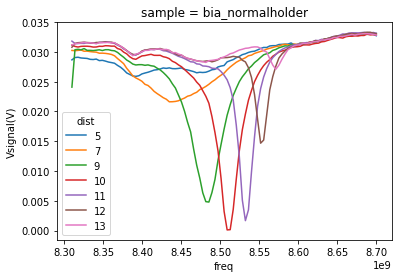

In [6]:
g = da_sw.plot(hue = 'dist')

# for ax in g.axes.flatten():
#     plot.removena_axes(ax)



In [7]:
da_sw_sampnum = da_sw.assign_coords(sample = range(len(da_sw.coords['sample'])))

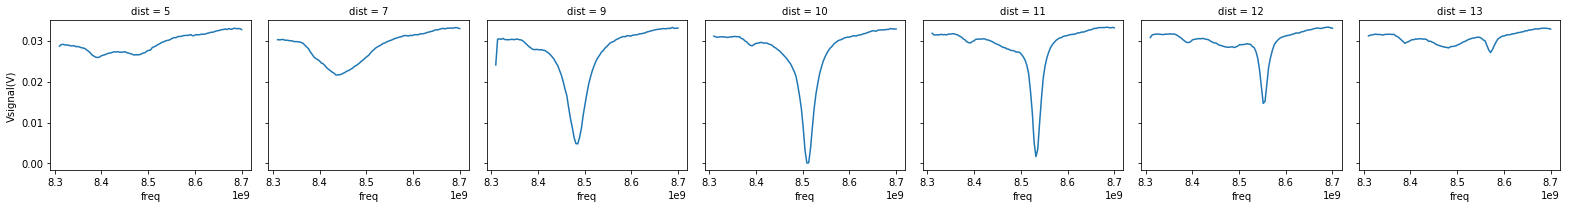

In [8]:
da_sw_sampnum.plot(col = 'dist')

In [9]:
import importlib
importlib.reload(load)

<module 'trmc.load' from 'C:\\Users\\aspit\\Git\\TRMC\\trmc\\load.py'>

In [32]:
das = []
das_bv = []

for samp in fps:
    direc = os.path.join(fps[samp],'FreqFluence')
    
    s_fps = load.freqfluence_flist(direc,file_re = '^(\d+)mm_Filter=\d+_Fluence=(.+?)_data.csv', file_groupnames = ['dist','fluence'],direction_used = False)

    da_fps = xr.DataArray.from_series(s_fps)
    for dist in da_fps.coords['dist'].values:
        s_fps_dist = da_fps.sel(dist = dist).to_series().dropna()
        print('Loading data for ' + samp)
        s,backvs = load.freqfluence_load(s_fps_dist, sub_lowpow=False)

        print('Converting to Dataset')
        da = xr.DataArray.from_series(s)
        da = da.chunk({'time': 2000})
        da = da.expand_dims('sample')
        da['sample'] = [samp]
        da = da.expand_dims('dist')
        da['dist'] = [int(dist)]

        das.append(da)

        da_bv = xr.DataArray.from_series(backvs)
        da_bv = da_bv.expand_dims('sample')
        da_bv['sample'] = [samp]
        da_bv = da_bv.expand_dims('dist')
        da_bv['dist'] = [int(dist)]
        das_bv.append(da_bv)

da_dv = xr.concat(das, dim = 'dist')
da_dv = da_dv*(-1) #voltage is flipped

da_dv.name = '$\Delta V$ (V)'
da_dv.attrs = dict(units = 'V', long_name = '$\Delta V$')

da_dv.coords['freq'].attrs = dict(units = 'Hz', long_name = 'Frequency')
da_dv.coords['fluence'].attrs = dict(units = '$\#/cm^2/pulse$', long_name = 'Fluence')
da_dv.coords['time'].attrs = dict(units = 'ns', long_name = 'Time')

da_bv = xr.concat(das_bv,dim = 'dist')

print('done')

no match for file 8mm_Filter=01_Fluence=4.814E+14_voltage_image.png
Loading data for bia_normalholder
Converting to Dataset
Loading data for bia_normalholder
Converting to Dataset
Loading data for bia_normalholder
Converting to Dataset
Loading data for bia_normalholder
Converting to Dataset
Loading data for bia_normalholder
Converting to Dataset
Loading data for bia_normalholder
Converting to Dataset
done


In [34]:
%store da_dv
%store da_bv

Stored 'da_dv' (DataArray)
Stored 'da_bv' (DataArray)


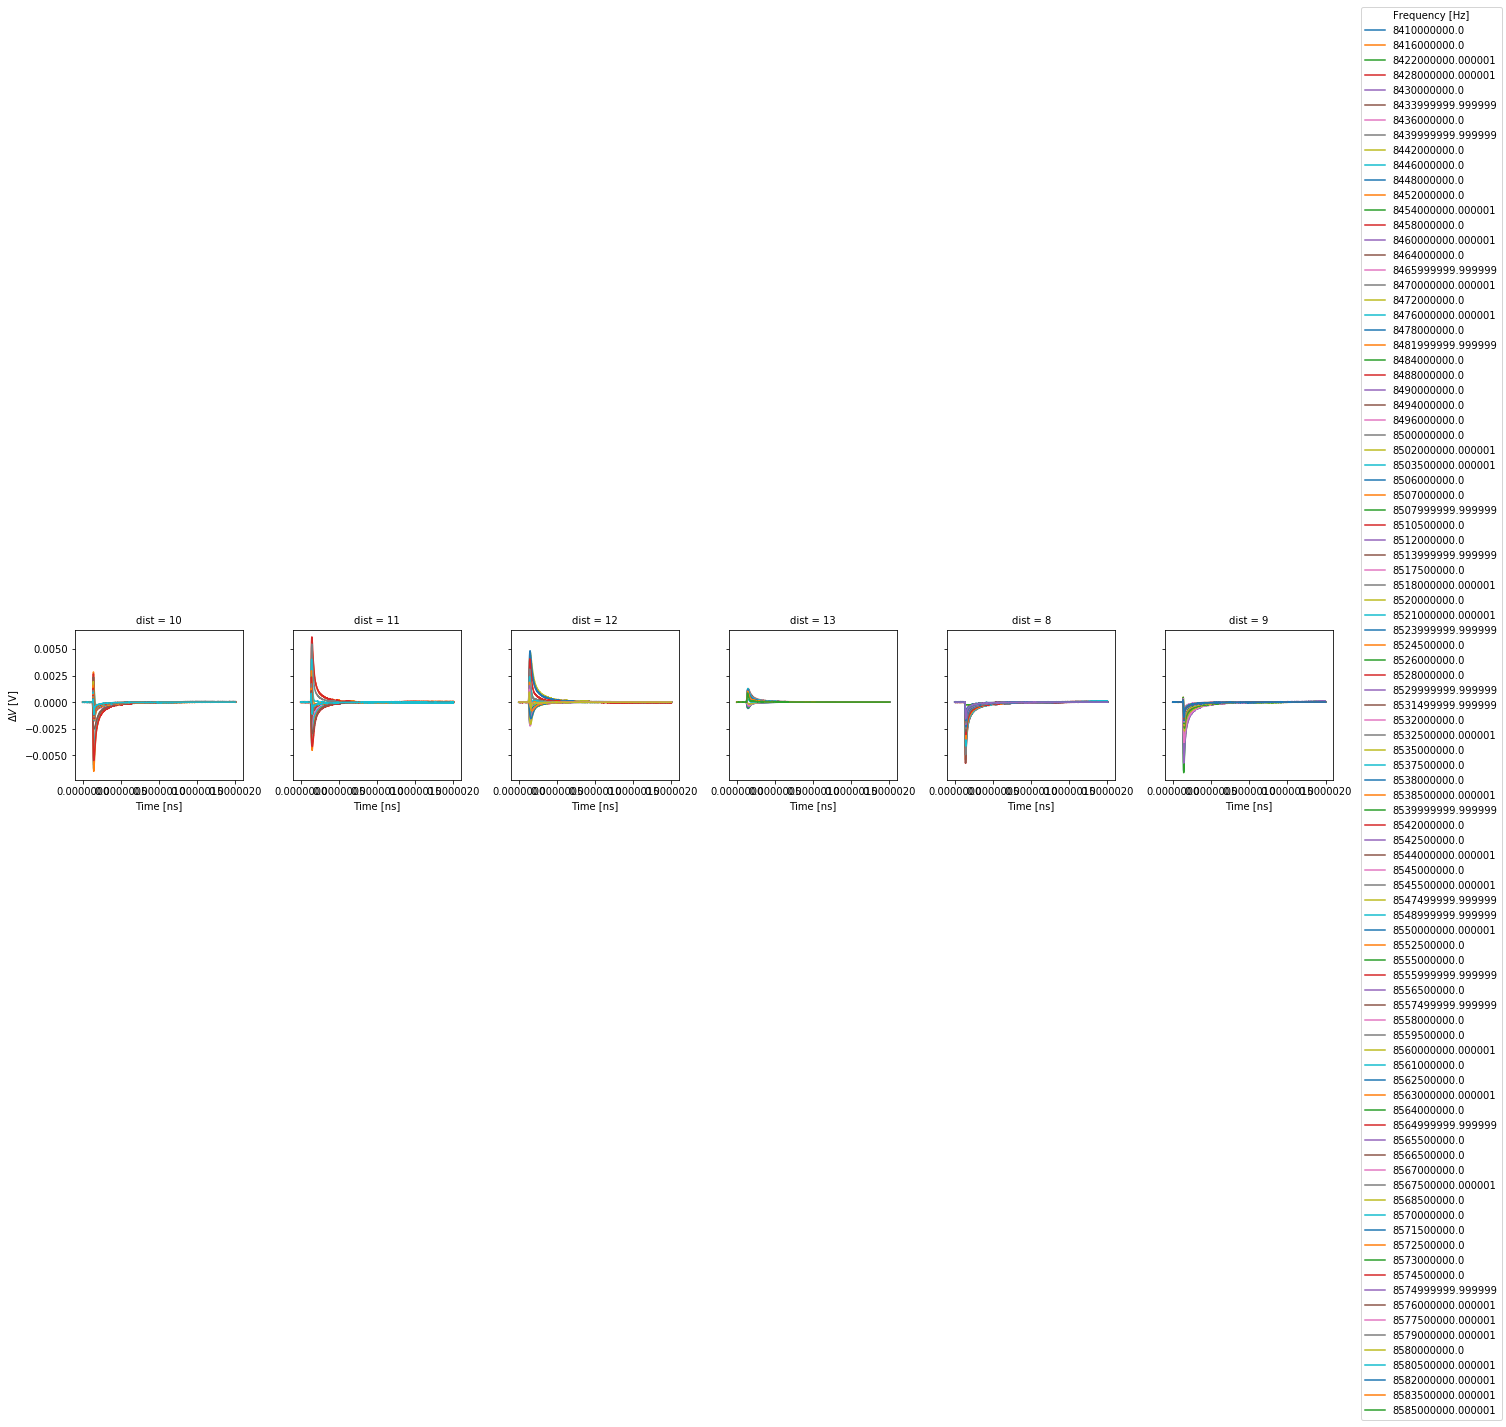

In [24]:
da_dv.isel(sample =0, fluence = 0,direction = 0).plot(col = 'dist', hue = 'freq')

In [25]:
da_dv = da_dv.load()

In [26]:
col = None if (len(da_dv.indexes['sample']) == 1)  else 'sample'
row = None if (len(da_dv.indexes['direction']) == 1)  else 'direction'
timeslice = slice(0e-9,1000e-9)

C:\Users\aspit\Anaconda3\envs\py36\lib\site-packages\xarray\core\nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


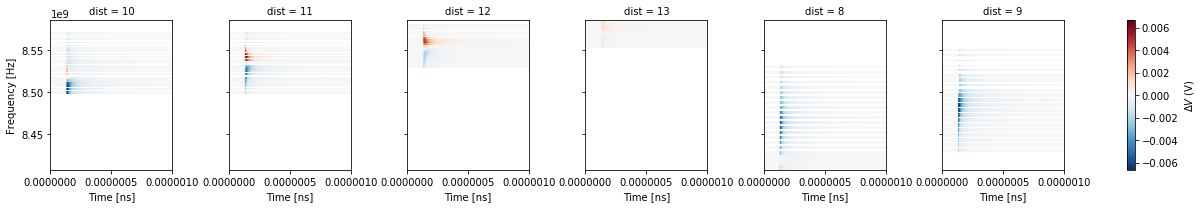

In [27]:
g = da_dv.dropna('fluence','all').mean('fluence').sel(time = timeslice).plot(x = 'time', y = 'freq', row = row, col = 'dist')

axs = g.axes.flatten() if type(g.axes) == np.ndarray else [g.axes]
# for ax in axs:
#     ax.xaxis.set_major_formatter(FuncFormatter(plot.exp_formatter(-9).func))

In [28]:
da_dv

<xarray.DataArray '$\\Delta V$ (V)' (dist: 6, sample: 1, direction: 1, freq: 93, fluence: 1, time: 10000)>
array([[[[[[nan, ..., nan]],

          ...,

          [[nan, ..., nan]]]]],




       ...,




       [[[[[nan, ..., nan]],

          ...,

          [[nan, ..., nan]]]]]])
Coordinates:
  * direction  (direction) object 'U'
  * freq       (freq) float64 8.41e+09 8.416e+09 ... 8.584e+09 8.585e+09
  * fluence    (fluence) object '4.814E+14'
  * time       (time) float64 0.0 2e-10 4e-10 6e-10 ... 1.999e-06 2e-06 2e-06
  * sample     (sample) <U16 'bia_normalholder'
  * dist       (dist) object '10' '11' '12' '13' '8' '9'
Attributes:
    units:      V
    long_name:  $\Delta V$

In [29]:
da_sw = load.sweeps2ds(fps,regex = 'Sweep_beforelaser_(\d+)mm_final_exp.csv', groupnames= ['dist'])['Vsignal(V)']

da_sw = da_sw.assign_coords(dist = [int(dist) for dist in da_sw.coords['dist']])

da_sw = da_sw.sortby('dist')

In [30]:
da_sw.assign_coords(direction = 'U').expand_dims('direction').expand_dims('freqt').assign_coords(freqt = da_sw.coords['freq'])

<xarray.DataArray 'Vsignal(V)' (freqt: 1, direction: 1, dist: 4, sample: 1, freq: 68)>
array([[[[[0.024996, ...,      nan]],

         ...,

         [[     nan, ..., 0.030238]]]]])
Coordinates:
  * dist       (dist) int32 8 10 12 13
  * freq       (freq) int64 8410000000 8416000000 ... 8583500000 8585000000
  * sample     (sample) <U16 'bia_normalholder'
  * direction  (direction) <U1 'U'
    freqt      (freq) int64 8410000000 8416000000 ... 8583500000 8585000000